Видео лабораторной: https://youtu.be/MEXjEUyD0qU

TG: https://t.me/data_science_news



---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
from statsmodels.graphics.regressionplots import plot_partregress_grid
#from stargazer.stargazer import Stargazer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import RocCurveDisplay

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Логистическая регрессия (бинарный вариант)

## Одномерный случай

Пусть нам даны пары наблюдений $(Y_1,X_1),...,(Y_n,X_n)$, где $Y_i$ имеет бинарный вид $\{0,1\}$, "Да/Нет", "Включено/Выключено" и так далее.

Нам необходима модель классификации, имеющая вероятностную природу, выраженную в виде $p(X)=\mathbb{P}(Y=1|X)$.

**Логистическая функция:**

$$p(X)=\frac{e^{\beta_0+\beta_1 X}}{1+e^{\beta_0+\beta_1X}}$$

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_logistic_001.png)

_Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py_

**Интуитивно** отношение

$$\frac{p(X)}{1-p(X)}=e^{\beta_0+\beta_1 X}$$

можно рассматривать как соотношение шансов. Если "шансы" стремятся к $0$ то вероятность события маленькая, если к $\infty$, то большая.

Пример: вероятность победы бойца в финале турнира UFC $p(X)=0.8$. Соотношение шансов принимает конкретный вид: $\frac{0.8}{1-0.8}=4$. Если вероятность победы маленькая $p(X)=0.1$, то $\frac{0.1}{1-0.1} \approx 0.1$

Прологорифмировав обе части получим лог-соотношение шансов **(logit, log odds)**:

$$log\frac{p(X)}{1-p(X)}=\beta_0+\beta_1 X$$

при этом, правая часть уравнения принимает линейный вид.


## Многомерный случай

Пусть нам даны пары наблюдений $(Y_1,X_1),...,(Y_n,X_n)$, где $Y_i$ имеет бинарный вид $\{0,1\}$, а $X \in R^d$.

Тогда:

$$\log\frac{p(X)}{1-p(X)}=\beta_0+\beta_1 X^1 + ... + \beta_d X^d = \bf{X \beta}$$

$$p(\bf{X})=\frac{e^{\bf{X \beta}}}{1+e^{\bf{X \beta}}}$$

## Оценка коэффициентов

Лог-функция максимального правдоподобия **(log-likelihood)** имеет вид:

$$\ell(\beta) = \Sigma_{i=1}^N \log p_i(X_i,\beta)$$

$$\ell(\beta) = \Sigma_{i=1}^N \left\{ y_i \log p(x_i, \beta) + (1 - y_i) \log (1 - p(x_i, \beta)) \right\} = \Sigma_{i=1}^N \left\{ y_i \beta^T x_i - \log(1+ e^{\beta^Tx_i})\right\}$$

Для максимизации лог-функции максимального правдоподобия:

$$\frac {\partial \ell (\beta)}{\partial \beta} = \Sigma_{i=1}^N x_i(y_i-p(x_i;\beta))$$

Так как у нас получается $d+1$ уравнений нелинейных относительно $\beta$, решения в аналитической форме не сущестует. Применяются методы [следующие](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.fit.html#statsmodels.discrete.discrete_model.Logit.fit) оптимизации.

## Прогноз новых значений

$$\hat{p}(\bf{X})=\frac{e^{\bf{X \hat{\beta}}}}{1+e^{\bf{X \hat{\beta}}}}$$

# Модель предсказания оползневых явлений во Владивостоке по данным осадков

Код и данные: https://gist.github.com/jamm1985/39783d2e6f20340116d6e14a73749fe6

Статья: Stepnova, Y.A., Stepnov, A.A., Konovalov, A.V. et al. Predictive Model of Rainfall-Induced Landslides in High-Density Urban Areas of the South Primorsky Region (Russia). Pure Appl. Geophys. (2021). https://doi.org/10.1007/s00024-021-02822-y

Статья онлайн: https://rdcu.be/cpW0j

Хабр: https://habr.com/ru/post/573012/


## Подготовка данных

In [ ]:
!head "/content/drive/MyDrive/DATA/landslide_cases/DATA/wr43988/wr43988.txt"

31960;1914; 1; 1;9;     ;     ;     ;     
31960;1914; 1; 2;9;     ;     ;     ;     
31960;1914; 1; 3;9;     ;     ;     ;     
31960;1914; 1; 4;9;     ;     ;     ;     
31960;1914; 1; 5;9;     ;     ;     ;     
31960;1914; 1; 6;9;     ;     ;     ;     
31960;1914; 1; 7;9;     ;     ;     ;     
31960;1914; 1; 8;9;     ;     ;     ;     
31960;1914; 1; 9;9;     ;     ;     ;     
31960;1914; 1;10;9;     ;     ;     ;     


In [ ]:
# read csv from wr43988.zip with day Temp and Rainfall data
# Vladivostok station
# source http://meteo.ru/it/178-aisori
rainfall_raw = pd.read_csv(
        "/content/drive/MyDrive/DATA/landslide_cases/DATA/wr43988/wr43988.txt",
        sep=";",
        header=None,
        parse_dates=[[1, 2, 3]],
        skipinitialspace=True,
        na_values=" ")

In [ ]:
rainfall_raw

,1_2_3,0,4,5,6,7,8
0,1914-01-01,31960,9,NaN,NaN,NaN,NaN
1,1914-01-02,31960,9,NaN,NaN,NaN,NaN
2,1914-01-03,31960,9,NaN,NaN,NaN,NaN
3,1914-01-04,31960,9,NaN,NaN,NaN,NaN
4,1914-01-05,31960,9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38802,2020-03-27,31960,0,-1.9,2.4,5.5,1.1
38803,2020-03-28,31960,0,-1.6,1.2,4.6,0.0
38804,2020-03-29,31960,0,-1.0,3.3,7.8,0.0
38805,2020-03-30,31960,0,0.2,2.7,6.4,0.0


In [ ]:
# set column names from data description fld43988a0.txt
rainfall_raw.columns =\
    ['date',
        'index_vmo',
        'temperature_quality_feature',
        'min_day_temp',
        'avg_day_temp',
        'max_day_temp',
        'total_rainfall']
print("count NA for Temp and Rainfall data \n{}".format(
    rainfall_raw.isna().sum()))

count NA for Temp and Rainfall data 
date                              0
index_vmo                         0
temperature_quality_feature       0
min_day_temp                   1269
avg_day_temp                   1236
max_day_temp                   1631
total_rainfall                 1241
dtype: int64


In [ ]:
# drop index_vmp and temperature_quality_feature column
rainfall_raw = rainfall_raw.drop(columns=['index_vmo',
                                          'temperature_quality_feature'])

In [ ]:
!head /content/drive/MyDrive/DATA/landslide_cases/DATA/wr43990/wr43990.txt

31960;1963; 1; 1;999.9;999.9;999.9;999.9; -9.8; -5.4; -2.7; -0.8;  1.2;  2.5;  4.9;999.9
31960;1963; 1; 2;999.9;999.9;999.9;999.9; -9.0; -5.8; -3.2; -0.8;  1.2;  2.5;  4.8;999.9
31960;1963; 1; 3;999.9;999.9;999.9;999.9;-10.2; -5.6; -3.4; -0.9;  1.1;  2.4;  4.6;999.9
31960;1963; 1; 4;999.9;999.9;999.9;999.9;-12.0; -6.5; -3.6; -1.3;  1.0;  2.3;  4.5;999.9
31960;1963; 1; 5;999.9;999.9;999.9;999.9;-12.0; -7.2; -3.9; -1.6;  0.6;  2.3;  4.5;999.9
31960;1963; 1; 6;999.9;999.9;999.9;999.9;-11.0; -7.3; -4.6; -1.6;  0.7;  2.2;  4.5;999.9
31960;1963; 1; 7;999.9;999.9;999.9;999.9;-10.1; -7.2; -4.4; -1.7;  0.6;  2.1;  4.5;999.9
31960;1963; 1; 8;999.9;999.9;999.9;999.9;-10.6; -7.1; -4.4; -1.9;  0.6;  1.9;  4.5;999.9
31960;1963; 1; 9;999.9;999.9;999.9;999.9;-10.6; -7.5; -4.6; -2.1;  0.5;  1.8;  4.5;999.9
31960;1963; 1;10;999.9;999.9;999.9;999.9;-11.3; -7.6; -4.8; -2.4;  0.1;  1.6;  4.3;999.9


In [ ]:
# read csv from wr43990.zip with day Soil temperature at depth
# Vladivostok station
# source http://meteo.ru/it/178-aisori
soil_temp_depth_raw = pd.read_csv(
        "/content/drive/MyDrive/DATA/landslide_cases/DATA/wr43990/wr43990.txt",
        sep=";",
        header=None,
        parse_dates=[[1, 2, 3]],
        skipinitialspace=True,
        na_values="999.9")

In [ ]:
soil_temp_depth_raw

,1_2_3,0,4,5,6,7,8,9,10,11,12,13,14,15
0,1963 1 1,31960,NaN,NaN,NaN,NaN,-9.8,-5.4,-2.7,-0.8,1.2,2.5,4.9,NaN
1,1963 1 2,31960,NaN,NaN,NaN,NaN,-9.0,-5.8,-3.2,-0.8,1.2,2.5,4.8,NaN
2,1963 1 3,31960,NaN,NaN,NaN,NaN,-10.2,-5.6,-3.4,-0.9,1.1,2.4,4.6,NaN
3,1963 1 4,31960,NaN,NaN,NaN,NaN,-12.0,-6.5,-3.6,-1.3,1.0,2.3,4.5,NaN
4,1963 1 5,31960,NaN,NaN,NaN,NaN,-12.0,-7.2,-3.9,-1.6,0.6,2.3,4.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18595,2012 12 27,31960,NaN,NaN,NaN,NaN,-6.1,-1.4,NaN,1.5,3.4,4.7,6.7,NaN
18596,2012 12 28,31960,NaN,NaN,NaN,NaN,-6.0,-1.7,NaN,1.4,3.3,4.6,6.7,NaN
18597,2012 12 29,31960,NaN,NaN,NaN,NaN,-6.1,-1.9,NaN,1.2,3.1,4.5,6.4,NaN
18598,2012 12 30,31960,NaN,NaN,NaN,NaN,-5.4,-2.1,NaN,1.1,3.1,4.5,6.5,NaN


In [ ]:
# set column names from data description fld43990a0.txt
soil_temp_depth_raw.columns =\
    ['date',
        'index_vmo',
        'temp_2_cm',
        'temp_5_cm',
        'temp_10_cm',
        'temp_15_cm',
        'temp_20_cm',
        'temp_40_cm',
        'temp_60_cm',
        'temp_80_cm',
        'temp_120_cm',
        'temp_160_cm',
        'temp_240_cm',
        'temp_320_cm']
print("count NA for Soil temperature at depth data \n{}".format(
    soil_temp_depth_raw.isna().sum()))

count NA for Soil temperature at depth data 
date               0
index_vmo          0
temp_2_cm      18599
temp_5_cm      18600
temp_10_cm     18600
temp_15_cm     18600
temp_20_cm      4019
temp_40_cm      4035
temp_60_cm     16140
temp_80_cm       756
temp_120_cm      704
temp_160_cm      798
temp_240_cm      735
temp_320_cm    18599
dtype: int64


In [ ]:
# convert date column to datetime64 and mark NaT out-of-bounds dates
soil_temp_depth_raw['date'] =\
    pd.to_datetime(soil_temp_depth_raw['date'], errors='coerce')
# drop out-of-bounds dates rows
soil_temp_depth_raw =\
    soil_temp_depth_raw[soil_temp_depth_raw['date'].notnull()]

In [ ]:
soil_temp_depth_raw

,date,index_vmo,temp_2_cm,temp_5_cm,temp_10_cm,temp_15_cm,temp_20_cm,temp_40_cm,temp_60_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,temp_320_cm
0,1963-01-01,31960,NaN,NaN,NaN,NaN,-9.8,-5.4,-2.7,-0.8,1.2,2.5,4.9,NaN
1,1963-01-02,31960,NaN,NaN,NaN,NaN,-9.0,-5.8,-3.2,-0.8,1.2,2.5,4.8,NaN
2,1963-01-03,31960,NaN,NaN,NaN,NaN,-10.2,-5.6,-3.4,-0.9,1.1,2.4,4.6,NaN
3,1963-01-04,31960,NaN,NaN,NaN,NaN,-12.0,-6.5,-3.6,-1.3,1.0,2.3,4.5,NaN
4,1963-01-05,31960,NaN,NaN,NaN,NaN,-12.0,-7.2,-3.9,-1.6,0.6,2.3,4.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18595,2012-12-27,31960,NaN,NaN,NaN,NaN,-6.1,-1.4,NaN,1.5,3.4,4.7,6.7,NaN
18596,2012-12-28,31960,NaN,NaN,NaN,NaN,-6.0,-1.7,NaN,1.4,3.3,4.6,6.7,NaN
18597,2012-12-29,31960,NaN,NaN,NaN,NaN,-6.1,-1.9,NaN,1.2,3.1,4.5,6.4,NaN
18598,2012-12-30,31960,NaN,NaN,NaN,NaN,-5.4,-2.1,NaN,1.1,3.1,4.5,6.5,NaN


In [ ]:
# drop index_vmo column and columns with NA more than 50%
soil_temp_depth_raw =\
    soil_temp_depth_raw.drop(
            columns=['index_vmo',
                     'temp_2_cm',
                     'temp_5_cm',
                     'temp_10_cm',
                     'temp_15_cm',
                     'temp_60_cm',
                     'temp_320_cm'])

In [ ]:
# join two dataframes by date key
DATA = rainfall_raw.join(
    soil_temp_depth_raw.set_index('date'), on='date')
print("count NA for accumulated DATA \n{}".format(
    DATA.isna().sum()))

count NA for accumulated DATA 
date                  0
min_day_temp       1269
avg_day_temp       1236
max_day_temp       1631
total_rainfall     1241
temp_20_cm        24226
temp_40_cm        24242
temp_80_cm        20963
temp_120_cm       20911
temp_160_cm       21005
temp_240_cm       20942
dtype: int64


In [ ]:
DATA

,date,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm
0,1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1914-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1914-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1914-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1914-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
38802,2020-03-27,-1.9,2.4,5.5,1.1,NaN,NaN,NaN,NaN,NaN,NaN
38803,2020-03-28,-1.6,1.2,4.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
38804,2020-03-29,-1.0,3.3,7.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN
38805,2020-03-30,0.2,2.7,6.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# drop rows before 1946-01-01
DATA = DATA[DATA['date'] >= '1946-01-01']
DATA = DATA.reset_index(drop=True)

In [ ]:
# landslide cases
landslides = pd.read_excel("/content/drive/MyDrive/DATA/landslide_cases/DATA/landslides_cases.xlsx")
# join data
DATA = DATA.join(landslides.set_index('DATE'), on='date')

In [ ]:
DATA

,date,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE
0,1946-01-01,-18.5,-15.2,-10.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1946-01-02,-18.6,-14.6,-11.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1946-01-03,-15.5,-14.1,-9.5,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1946-01-04,-18.1,-15.4,-12.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1946-01-05,-20.7,-17.4,-13.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
27114,2020-03-27,-1.9,2.4,5.5,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27115,2020-03-28,-1.6,1.2,4.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27116,2020-03-29,-1.0,3.3,7.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27117,2020-03-30,0.2,2.7,6.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# assume that all landslide did not occur at any other day
DATA['LANDSLIDE'] = DATA['LANDSLIDE'].fillna(0)

In [ ]:
DATA.describe()

,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE
count,26978.000000,26978.000000,26978.000000,26974.000000,14581.000000,14565.000000,17844.000000,17896.000000,17802.000000,17865.000000,27119.000000
mean,1.753970,4.630970,8.736370,2.277745,6.274192,6.510223,6.482784,6.510002,6.607347,6.716339,0.001254
std,11.887439,11.604124,11.642561,8.312972,9.553991,8.454957,6.918749,5.764099,4.981636,3.775955,0.035387
min,-30.300000,-27.100000,-24.100000,0.000000,-18.600000,-13.600000,-6.800000,-3.700000,-1.800000,-8.900000,0.000000
25%,-8.300000,-5.000000,-0.800000,0.000000,-1.900000,-0.800000,-0.100000,0.500000,1.600000,3.200000,0.000000
50%,3.300000,6.400000,10.600000,0.000000,6.700000,6.700000,6.400000,6.300000,6.400000,6.500000,0.000000
75%,12.000000,14.600000,18.600000,0.600000,15.200000,14.600000,13.100000,12.000000,11.300000,10.300000,0.000000
max,24.700000,27.500000,33.600000,243.500000,24.100000,21.400000,45.400000,17.100000,15.800000,14.300000,1.000000


In [ ]:
# add cumulative rainfall during YEAR
# I trust there is more elegant and efficient way to do this!
DATA['cumm_year_rainfall'] = 0.0
for i in range(0, len(DATA)):
    DATA.cumm_year_rainfall[i] =\
        DATA[(DATA['date'] > DATA.iloc[i].date - pd.offsets.YearBegin(1))
             & (DATA['date'] < DATA.iloc[i].date)]['total_rainfall'].sum()


In [ ]:
# add antecedent rainfall values for each row
# IETD = 1 day, see Hong, M., Kim, J., Jeong, S., 2018. Landslides 15, 523–534.
# and again there is more elegant way to do this!
DATA['antecedent_rainfall'] = 0.0
for i in range(1, len(DATA)):
    j = 1
    antecedent_rainfall_value = 0
    while DATA.iloc[i-j].total_rainfall != 0:
        if pd.isna(DATA.total_rainfall.iloc[i-j]):
            pass
        else:
            antecedent_rainfall_value +=\
                DATA.iloc[i-j].total_rainfall
        j += 1
        # print(i, j)
    DATA.antecedent_rainfall[i] = antecedent_rainfall_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
DATA

,date,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE,cumm_year_rainfall,antecedent_rainfall
0,1946-01-01,-18.5,-15.2,-10.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,1946-01-02,-18.6,-14.6,-11.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,1946-01-03,-15.5,-14.1,-9.5,0.2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,1946-01-04,-18.1,-15.4,-12.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.2,0.2
4,1946-01-05,-20.7,-17.4,-13.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27114,2020-03-27,-1.9,2.4,5.5,1.1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,83.7,1.1
27115,2020-03-28,-1.6,1.2,4.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.8,2.2
27116,2020-03-29,-1.0,3.3,7.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.8,0.0
27117,2020-03-30,0.2,2.7,6.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.8,0.0


In [ ]:
# summary table the DATA
DATA.describe()

,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE,cumm_year_rainfall,antecedent_rainfall
count,26978.000000,26978.000000,26978.000000,26974.000000,14581.000000,14565.000000,17844.000000,17896.000000,17802.000000,17865.000000,27119.000000,27119.000000,27119.000000
mean,1.753970,4.630970,8.736370,2.277745,6.274192,6.510223,6.482784,6.510002,6.607347,6.716339,0.001254,368.966621,5.977912
std,11.887439,11.604124,11.642561,8.312972,9.553991,8.454957,6.918749,5.764099,4.981636,3.775955,0.035387,334.200810,20.362288
min,-30.300000,-27.100000,-24.100000,0.000000,-18.600000,-13.600000,-6.800000,-3.700000,-1.800000,-8.900000,0.000000,0.000000,0.000000
25%,-8.300000,-5.000000,-0.800000,0.000000,-1.900000,-0.800000,-0.100000,0.500000,1.600000,3.200000,0.000000,54.200000,0.000000
50%,3.300000,6.400000,10.600000,0.000000,6.700000,6.700000,6.400000,6.300000,6.400000,6.500000,0.000000,286.300000,0.000000
75%,12.000000,14.600000,18.600000,0.600000,15.200000,14.600000,13.100000,12.000000,11.300000,10.300000,0.000000,640.950000,1.200000
max,24.700000,27.500000,33.600000,243.500000,24.100000,21.400000,45.400000,17.100000,15.800000,14.300000,1.000000,1272.100000,335.300000


In [ ]:
# see landslides cases over day temp and rainfalls
CASES = DATA[DATA['LANDSLIDE'] == 1][[
        'date',
        'avg_day_temp',
        'total_rainfall',
        'cumm_year_rainfall',
        'antecedent_rainfall']]
print("All landslide cases\n{}".format(CASES))
print("And some stats about it\n{}".format(CASES.describe()))

All landslide cases
            date  avg_day_temp  total_rainfall  cumm_year_rainfall  \
235   1946-08-24          20.4            92.1               491.9   
236   1946-08-25          19.8           127.6               584.0   
3905  1956-09-10          14.5           178.1               667.6   
9371  1971-08-29          17.0            71.3               652.8   
9702  1972-07-25          19.7            94.4               278.7   
9718  1972-08-10          18.9           111.6               438.3   
9736  1972-08-28          14.7            75.7               583.1   
9768  1972-09-29           8.7            98.0               802.0   
10415 1974-07-08          16.4           106.8               574.9   
10502 1974-10-03          11.2            76.9              1064.3   
12282 1979-08-18          18.3           136.3               477.7   
13038 1981-09-12          12.5           160.2               548.1   
14113 1984-08-22          17.5           109.5               509.5   


<Figure size 432x288 with 0 Axes>

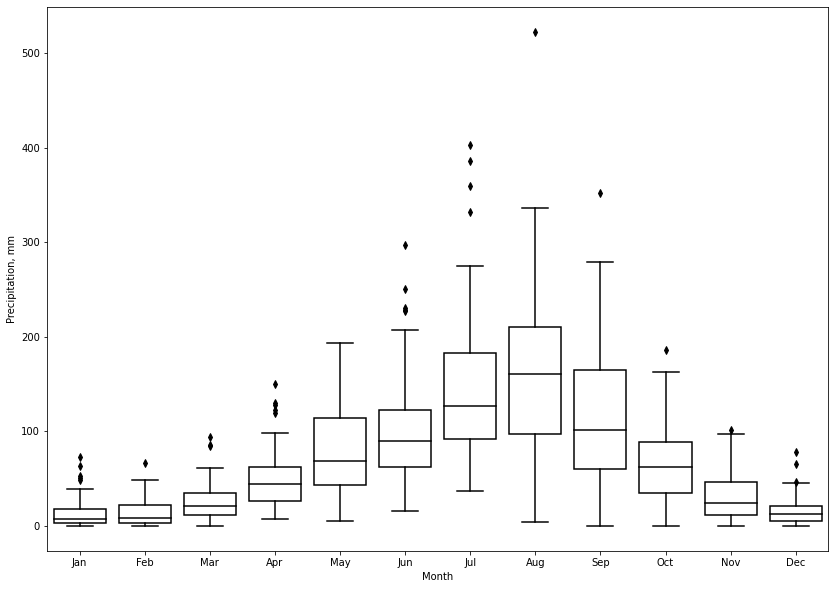

In [ ]:
# plot cumulative rainfall distributions by months
# Fig 3
RAINFAL_BY_MONTH =\
        DATA[['date', 'total_rainfall']].set_index('date').resample('M').sum()
RAINFAL_BY_MONTH['Month'] =\
        RAINFAL_BY_MONTH.index.strftime('%b')
plt.clf()
plt.figure(figsize=(14, 10))
ax = sns.boxplot(y="total_rainfall",
                 x="Month",
                 palette=["black"],
                 data=RAINFAL_BY_MONTH)
plt.setp(ax.artists, edgecolor='k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.ylabel('Precipitation, mm')
#plt.savefig('../FIGS/rainfall_by_month.png', dpi=600, format='png')
#plt.close()
plt.show()

<Figure size 432x288 with 0 Axes>

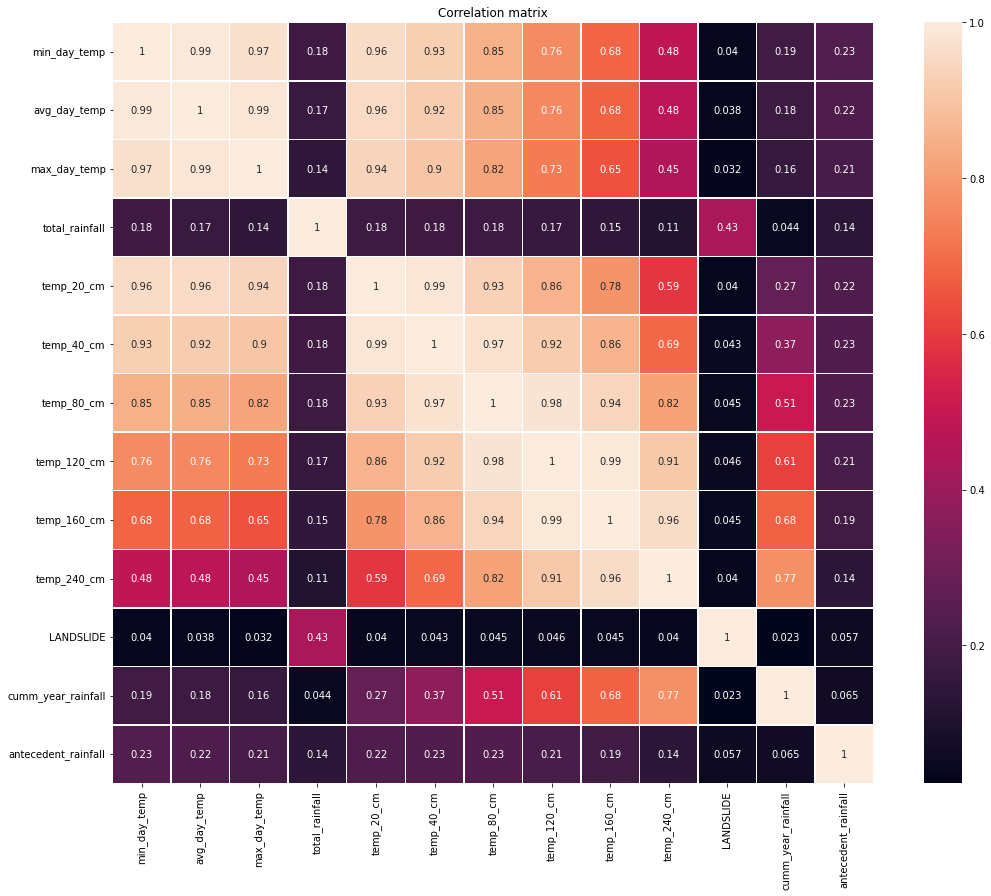

In [ ]:
# correlation matrix all the DATA
correlation_matrix = DATA.corr()
# clear plot object
plt.clf()
plt.figure(figsize=(18, 14))
# rename axis to human-like style
# plot and save fig
ax_1 = sns.heatmap(
        correlation_matrix,
        annot=True,
        square=True,
        linewidths=.5)
ax_1.set_title('Correlation matrix')
#plt.savefig("../FIGS/correlation_matrix.png", dpi=600, format='png')
plt.show()
#plt.close()

<Figure size 432x288 with 0 Axes>

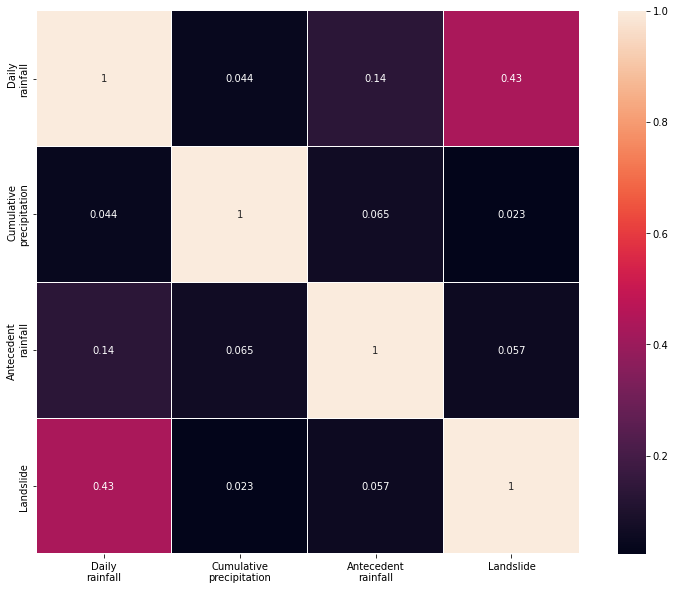

In [ ]:
# print only rainfall correlation matrix
# clear plot object
plt.clf()
correlation_matrix_rainfall =\
    DATA[['total_rainfall',
          'cumm_year_rainfall',
          'antecedent_rainfall',
          'LANDSLIDE']].corr()
lables = ["Daily\nrainfall",
          "Cumulative\nprecipitation",
          "Antecedent\nrainfall",
          "Landslide"]
correlation_matrix_rainfall.columns = lables
correlation_matrix_rainfall.index = lables
plt.figure(figsize=(14, 10))
# fix bug with text alignment on y-axes
# https://github.com/mwaskom/seaborn/issues/1820
plt.setp(plt.gca().yaxis.get_majorticklabels(), va="center")
ax_1 = sns.heatmap(
        correlation_matrix_rainfall,
        annot=True,
        square=True,
        linewidths=.5)
# ax_1.set_title('Correlation matrix')
#plt.savefig("../FIGS/correlation_matrix_rainfall.png", dpi=600, format='png')
plt.show()
# plt.close()

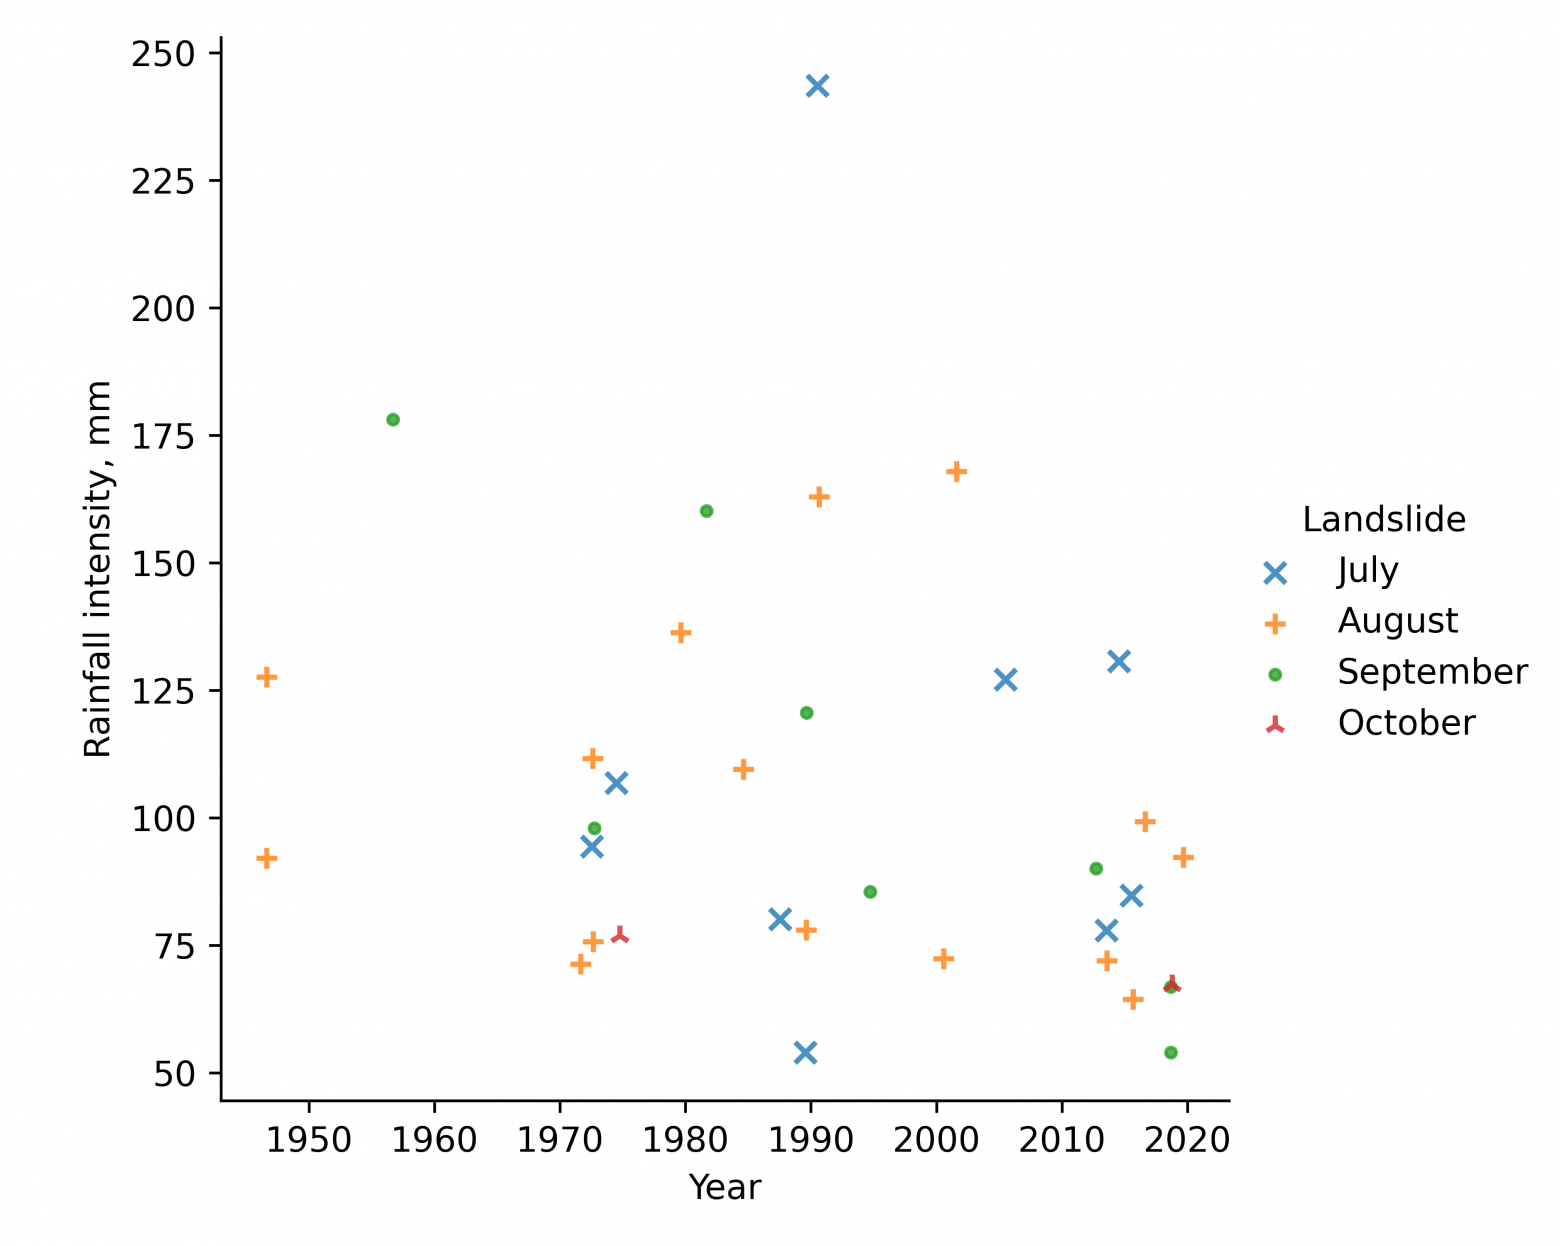

In [ ]:
# For logit: fight a QUASI-COMPLETE SEPARATION
rainfall_threshold =\
        CASES['total_rainfall'].min() - DATA['total_rainfall'].std()
print("Rainfall threshold is {}".format(rainfall_threshold))

Rainfall threshold is 45.687028344979474


## Логистическая регрессия

In [ ]:
# logit!
REGRESSION_SAMPLE = DATA[DATA['total_rainfall'] >= rainfall_threshold]
REGRESSION_SAMPLE = REGRESSION_SAMPLE.reset_index(drop=True)
REGRESSION_SAMPLE = REGRESSION_SAMPLE.astype({'LANDSLIDE': 'int32'})

In [ ]:
REGRESSION_SAMPLE

,date,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE,cumm_year_rainfall,antecedent_rainfall
0,1946-07-04,15.6,17.4,20.0,61.8,NaN,NaN,NaN,NaN,NaN,NaN,0,244.9,83.2
1,1946-07-31,16.6,17.8,21.2,59.2,NaN,NaN,NaN,NaN,NaN,NaN,0,350.9,0.0
2,1946-08-24,18.9,20.4,22.8,92.1,NaN,NaN,NaN,NaN,NaN,NaN,1,491.9,0.0
3,1946-08-25,18.1,19.8,21.6,127.6,NaN,NaN,NaN,NaN,NaN,NaN,1,584.0,92.1
4,1946-09-18,8.6,13.7,18.5,54.4,NaN,NaN,NaN,NaN,NaN,NaN,0,784.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2019-08-27,17.7,18.6,19.2,67.7,NaN,NaN,NaN,NaN,NaN,NaN,0,709.4,0.6
196,2019-08-28,17.1,18.5,19.5,92.3,NaN,NaN,NaN,NaN,NaN,NaN,1,777.1,68.3
197,2019-08-30,14.8,18.2,22.3,51.2,NaN,NaN,NaN,NaN,NaN,NaN,0,869.4,0.0
198,2019-10-26,1.3,5.1,10.7,47.5,NaN,NaN,NaN,NaN,NaN,NaN,0,988.6,6.4


In [ ]:
# summary table about train set
REGRESSION_SAMPLE.describe()

,min_day_temp,avg_day_temp,max_day_temp,total_rainfall,temp_20_cm,temp_40_cm,temp_80_cm,temp_120_cm,temp_160_cm,temp_240_cm,LANDSLIDE,cumm_year_rainfall,antecedent_rainfall
count,199.000000,199.000000,199.000000,200.000000,113.000000,113.000000,129.000000,129.000000,128.000000,129.000000,200.000000,200.000000,200.000000
mean,13.663819,15.541709,17.982412,71.221500,15.663717,15.300885,14.037984,12.667442,11.721094,10.058140,0.170000,481.522000,23.143500
std,5.282896,4.866399,4.879936,28.606165,4.628060,4.511760,4.133650,3.857686,3.544179,3.048737,0.376575,232.775952,38.210627
min,-6.600000,-4.800000,-3.000000,45.700000,-4.800000,-4.500000,-1.300000,-1.000000,-0.300000,0.700000,0.000000,0.000000,0.000000
25%,11.150000,13.500000,16.350000,52.350000,14.400000,14.400000,13.100000,12.000000,10.800000,8.800000,0.000000,329.175000,0.000000
50%,15.400000,16.500000,18.800000,61.500000,16.800000,16.600000,15.400000,14.200000,13.100000,11.100000,0.000000,481.350000,4.550000
75%,17.150000,18.600000,21.000000,80.525000,18.700000,18.000000,16.600000,15.000000,14.000000,12.200000,0.000000,618.325000,32.900000
max,21.800000,22.800000,26.700000,243.500000,22.300000,20.700000,18.400000,17.100000,15.700000,14.300000,1.000000,1168.300000,200.800000


In [ ]:
# R-style logit!
logit_mod = logit(
        "LANDSLIDE ~"
        " total_rainfall"
        " + antecedent_rainfall"
        " + cumm_year_rainfall",
        REGRESSION_SAMPLE)
logit_res = logit_mod.fit()
print(logit_res.summary())
print("\n")
print(logit_res.get_margeff().summary())

Optimization terminated successfully.
         Current function value: 0.309076
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              LANDSLIDE   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                  0.3220
Time:                        06:00:05   Log-Likelihood:                -61.815
converged:                       True   LL-Null:                       -91.177
Covariance Type:            nonrobust   LLR p-value:                 1.101e-12
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.0087      1.038     -6.750      0.000      -9.044      -4.974
to

## Оценка качества классификации



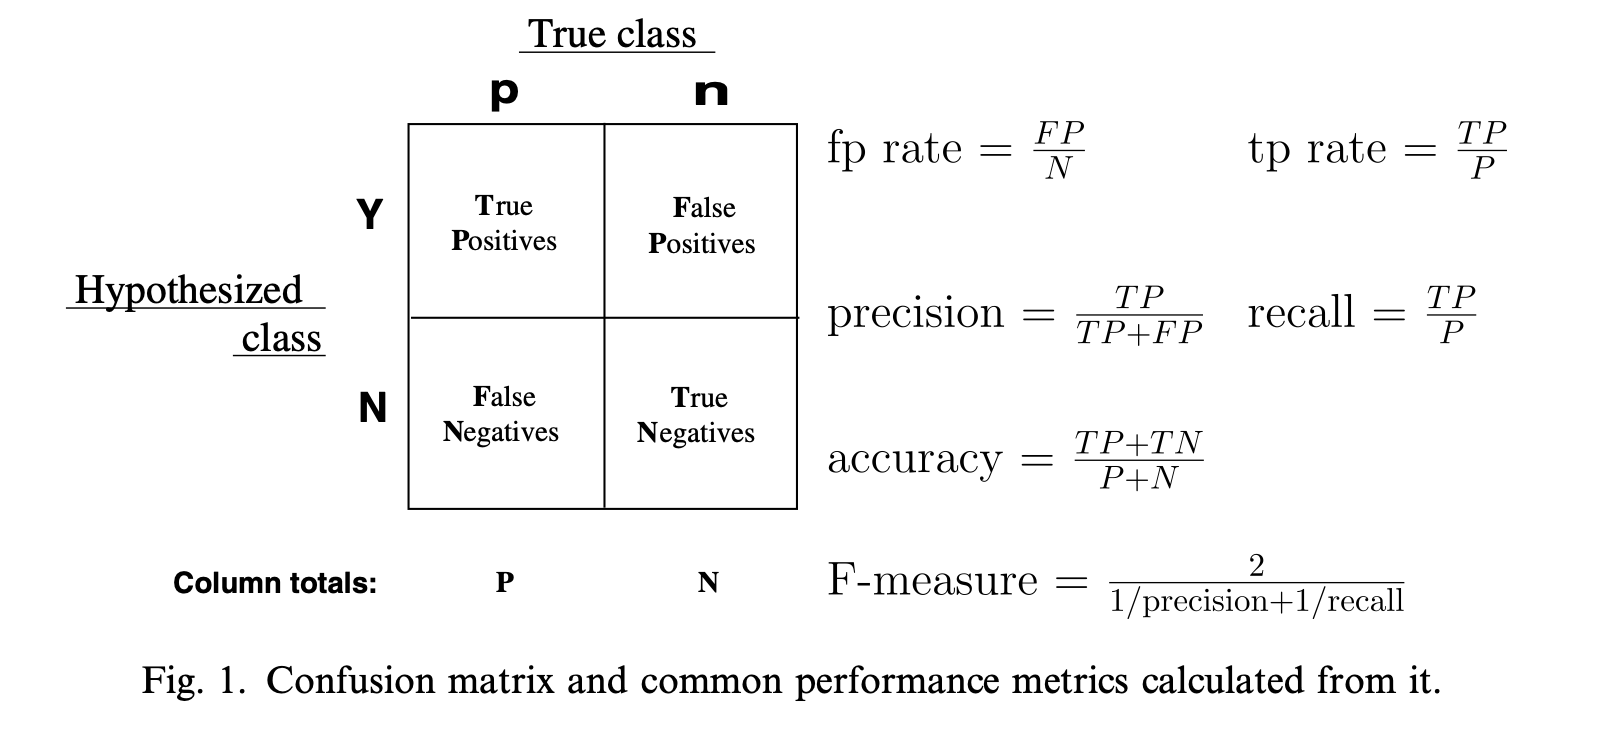

Fawcett, Tom. "An introduction to ROC analysis." Pattern recognition letters 27.8 (2006): 861-874.


In [ ]:
# optimal threshold
# see
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
y_true = REGRESSION_SAMPLE['LANDSLIDE'].to_numpy()
# calculate roc curves
precision, recall, thresholds =\
        precision_recall_curve(y_true, logit_res.predict())
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.243599, F-Score=0.629


In [ ]:
thresholds

array([0.08625797, 0.08718047, 0.08759984, 0.08826876, 0.0886369 ,
       0.08887859, 0.0897503 , 0.0911584 , 0.09150458, 0.09236057,
       0.0931606 , 0.09360548, 0.09485253, 0.09485771, 0.09509806,
       0.09665536, 0.09765863, 0.09847905, 0.09954223, 0.10119697,
       0.10260337, 0.1035642 , 0.10524491, 0.10640506, 0.1069877 ,
       0.10997065, 0.11004659, 0.11079508, 0.11280043, 0.11354093,
       0.11685505, 0.1172217 , 0.12236949, 0.12534867, 0.1290508 ,
       0.13165072, 0.13362002, 0.13370663, 0.13604427, 0.13894515,
       0.14265742, 0.14345886, 0.14953757, 0.15206924, 0.15640675,
       0.15642201, 0.15989156, 0.16225832, 0.16416409, 0.16522351,
       0.16685152, 0.17638684, 0.17751583, 0.18514804, 0.19585563,
       0.19838   , 0.2018498 , 0.20281203, 0.21207147, 0.21309559,
       0.21501528, 0.21581298, 0.22354901, 0.22587052, 0.24359914,
       0.2745241 , 0.32564048, 0.32964747, 0.33543702, 0.36407985,
       0.36617439, 0.36681052, 0.37164507, 0.37682043, 0.38176

<Figure size 432x288 with 0 Axes>

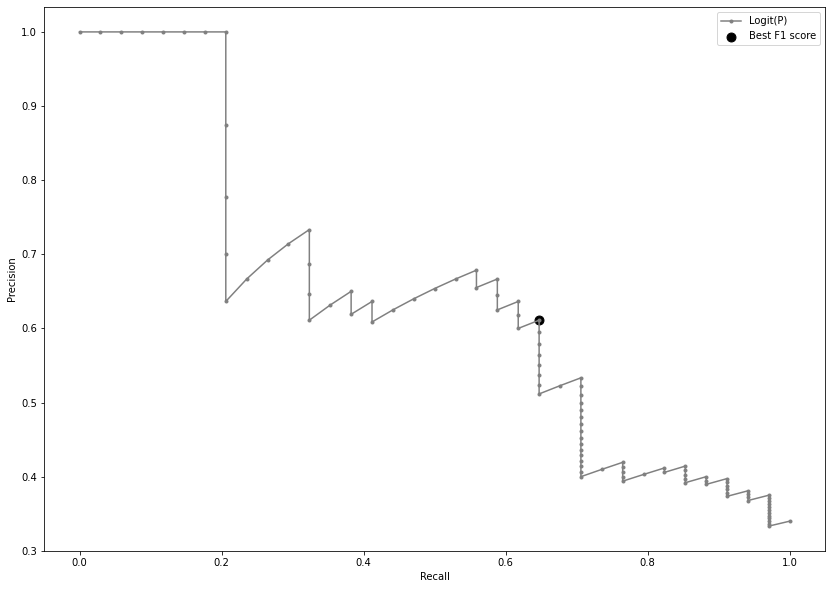

In [ ]:
# plot best threshold for logit model (Precision-Recall Curve)
plt.clf()
plt.figure(figsize=(14, 10))
plt.plot(recall, precision, marker='.',
         color='gray', label='Logit(P)')
plt.scatter(recall[ix], precision[ix], s=80,
            marker='o', color='black', label='Best F1 score')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
#plt.savefig("../FIGS/best_threshold.png", dpi=600, format='png')
#plt.close()
plt.show()

<Figure size 432x288 with 0 Axes>

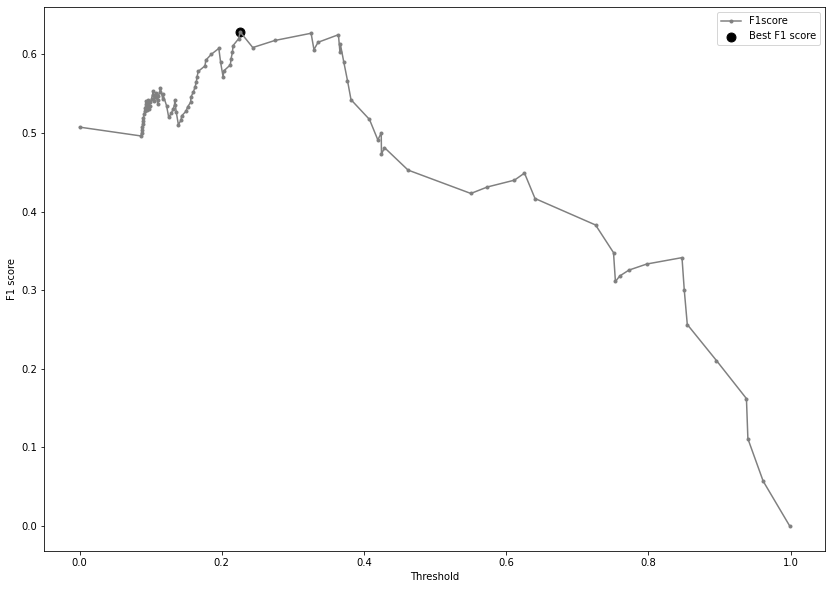

In [ ]:
# plot best threshold for logit model (F1 score and Balanced Accuracy Curve)
# calculate balanced accuracy
balanced_accuracy = np.array([])
for i in np.insert(thresholds, 0, 0.0):
    y_pred_iteration = np.where(logit_res.predict() >= i, 1, 0)
    balanced_accuracy =\
        np.append(balanced_accuracy,
                  balanced_accuracy_score(y_true, y_pred_iteration))
plt.clf()
plt.figure(figsize=(14, 10))
plt.plot(np.insert(thresholds, 0, 0.0), fscore, marker='.',
         color='gray', label='F1score')
# plt.plot(thresholds, balanced_accuracy, marker='x',
#          color='gray', label='Balanced Accuracy')
plt.scatter(np.insert(thresholds, 0, 0.0)[ix], fscore[ix], s=80,
            marker='o', color='black', label='Best F1 score')
# axis labels
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend()
# show the plot
#plt.savefig("../FIGS/F1score_threshold.png", dpi=600, format='png')
#plt.close()
plt.show()

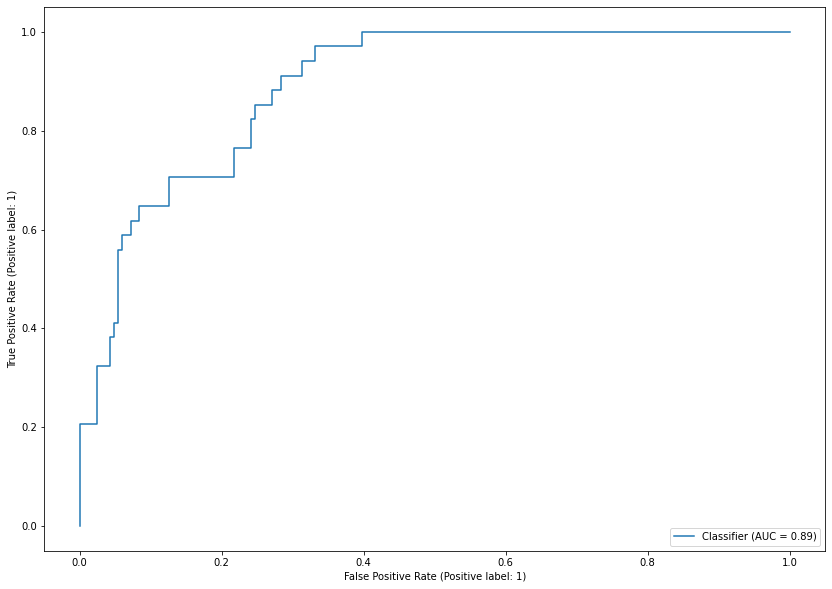

In [ ]:
y_true = REGRESSION_SAMPLE['LANDSLIDE'].to_numpy()
y_pred = logit_res.predict()
plt.rcParams['figure.figsize'] = [14, 10]
RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()

In [ ]:
# Model performance metrics
y_true = REGRESSION_SAMPLE['LANDSLIDE'].to_numpy()
y_pred = np.where(logit_res.predict() >= thresholds[ix], 1, 0)
# precision, recall, f1, overall accuracy
print(classification_report(y_true,
                            y_pred,
                            target_names=['Not a Landslide',
                                          'Landslide']))
# confusion matrix for the best threshold
print("confusion matrix\n{}".format(
    logit_res.pred_table(threshold=thresholds[ix])))
# balanced accuracy
print("ballanced accuracy {}".format(
        balanced_accuracy_score(y_true, y_pred)))

                 precision    recall  f1-score   support

Not a Landslide       0.93      0.92      0.92       166
      Landslide       0.61      0.65      0.63        34

       accuracy                           0.87       200
      macro avg       0.77      0.78      0.77       200
   weighted avg       0.87      0.87      0.87       200

confusion matrix
[[152.  14.]
 [ 13.  21.]]
ballanced accuracy 0.7813607370659107


[link](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)
$\mathrm{ballanced\ accuracy}=\frac{1}{2}(\frac{TP}{TP+FN}+\frac{TN}{TN+FP})$

In [ ]:
from sklearn.metrics import matthews_corrcoef

In [ ]:
matthews_corrcoef(y_true, y_pred)

0.5501914242271814